In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle as pkl
np.random.seed(7)

# Framework

Adapting the model from http://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [23]:
from keras.datasets import imdb

Using TensorFlow backend.


In [24]:
top_words = 5000 # how many of the top words to include
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words)
# truncate and pad input sequences
max_review_length = 500

In [39]:
np.shape(X_train)

(25000,)

In [150]:
all_words=[]
for i in X_train:
    all_words+=i

In [4]:
all_words=[]
for i in X_train:
    all_words.append(len(i))
print np.mean(all_words)
print np.median(all_words)
print np.min(all_words)
print np.max(all_words)

238.71364
178.0
11
2494


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b09ddd0>]], dtype=object)

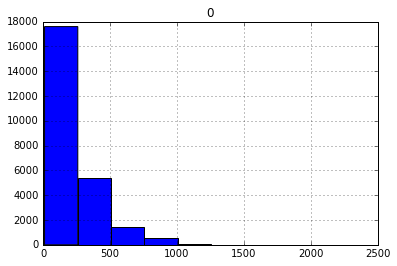

In [5]:
pd.DataFrame(all_words).hist()

In [6]:
len(X_train)

25000

Here they used on average 25000 examples with an average example length of 238. Then they padded each sequence so 

In [16]:
from keras.preprocessing import sequence
X_train2 = sequence.pad_sequences(X_train, maxlen=max_review_length)

In [18]:
np.shape(X_train[1])

(189,)

In [21]:
np.shape(X_train2[1])

(500,)

# Game plan
Ok so the game plan for me then is to

1. Identify unique words in the text (names, places, various entities) that could be used to distinguish shows and replace them with a generic identifier (xxNamexx)
2. Format the text into workable chunks. Chunks of size 200 words should be good
3. Train the model

# Load and clean text

Because British shows are notoriously short, I'll be combining The Office UK with Peep Show to get some extra data

In [2]:
us_folders=['office_us']
uk_folders=['office_uk','peep_show']

And let's try to make sure the classifier doesn't just capitalize on differences in English vs. American spelling

In [3]:
def replace_strings(x):
    replace_dic={" '":" ", \
                "okay":"ok",\
                 "Okay":"ok",\
                "\n":" ",\
                "apologise":"apologize",\
                "humour":"humor",\
                 "colour":"color",\
                 "flavour":"flavor",\
                 "favour":"favor",\
                 "labour":"labor",\
                 "neighbour":"neighbor",\
                 "favourite":"favorite",\
                 "centre":"center",\
                 "fibre":"fiber",\
                 "litre":"liter",\
                 "theatre":"theater",\
                 "organise":"organize",\
                 "recognise":"recognize",\
                 "realise":"realize",\
                 "analyse":"analyze",\
                 "defence":"defense",\
                 "offence":"offense",\
                 "licence":"license",\
                 "mum":"mom",\
                 "arsehole":"asshole",\
                 "tenner":'ten',\
                 "lads":"guys",\
                 "quid":"buck",\
                 "telly":"TV",\
                 " loo ": "bathroom ",\
                 " loo.":" bathroom.",\
                 "wanker ":"bastard ",\
                 "wanking ":"screwing ",\
                 "tits":"boobs",\
                 "wank ":"bastard ",\
                 "pint":"beer",\
                 "prick":"dick",\
                 "snog":"kiss",\
                 "crisps":"fries",\
                 "lazer":"laser"\
                 
                }
    for i in replace_dic.keys():
        x=x.replace(i,replace_dic[i])
    return x


How long should the passages be?

In [4]:
parse_size=200

In [5]:
uk_data=[]
uk_show=[]
for fold_name in uk_folders:
    uk_fold=os.path.join('data',fold_name)
    curr_files=os.listdir(uk_fold)
    curr_files=[i for i in curr_files if i[-3:]=='txt']
    for fname in curr_files:
        curr_fname=os.path.join(uk_fold,fname)
        with open(curr_fname,'rb') as curr_f:
            temp=replace_strings(curr_f.read().lower())
            uk_curr_text=unicode(temp.decode('utf-8'))
            uk_show.append(fold_name)
            uk_data.append(uk_curr_text)
        

In [6]:
sum([len(i)/(parse_size*5) for i in uk_data]) # 5 is ~ average word length

921

In [7]:
us_data=[]
us_show=[]
for fold_name in us_folders:
    us_fold=os.path.join('data',fold_name)
    curr_files=os.listdir(us_fold)
    curr_files=[i for i in curr_files if i[-3:]=='txt']    
    for fname in curr_files:
        curr_fname=os.path.join(us_fold,fname)
        with open(curr_fname,'rb') as curr_f:
            temp=replace_strings(curr_f.read().lower())
            us_curr_text=unicode(temp.decode('utf-8'))
            us_show.append(fold_name)
            us_data.append(us_curr_text)

In [8]:
sum([len(i)/(parse_size*5) for i in us_data])

1131

In [9]:
tfidf_words=[]
for j in range(1,302,20):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=1,
                                       max_features=j,
                                       stop_words='english')
#     tfidf_values=tfidf_vectorizer.fit_transform([' '.join(us_data), \
#                                                  ' '.join([i[0] for i in zip(uk_data,uk_show) if i[1]=='office_uk']), \
#                                                  ' '.join([i[0] for i in zip(uk_data,uk_show) if i[1]=='peep_show'])] \
#                                                )
    tfidf_values=tfidf_vectorizer.fit_transform([' '.join(us_data), \
                                             ' '.join(uk_data)]
                                           )
    tfidf_words.append(tfidf_vectorizer.get_feature_names())
    
    print 'New Words for TF-IDF='+str(j)
    if len(tfidf_words)>1:
        print [i for i in tfidf_words[-1] if i not in tfidf_words[-2]]
    else:
        print tfidf_words
    

New Words for TF-IDF=1
[[u'dwight']]
New Words for TF-IDF=21
[u'angela', u'darryl', u'dunder', u'erin', u'gabe', u'gareth', u'jez', u'kelly', u'kevin', u'mifflin', u'nancy', u'pam', u'phyllis', u'schrute', u'scranton', u'soph', u'sophie', u'stanley', u'suze', u'toby']
New Words for TF-IDF=41
[u'00', u'bollocks', u'cece', u'cock', u'corrigan', u'cos', u'creed', u'dobby', u'elena', u'halpert', u'holly', u'jo', u'mose', u'nellie', u'packer', u'philly', u'sabre', u'senator', u'store', u'tim']
New Words for TF-IDF=61
[u'arse', u'bloke', u'bullshit', u'california', u'cookies', u'danny', u'deangelo', u'fucked', u'gail', u'gerard', u'jlb', u'lice', u'loads', u'matt', u'mental', u'mural', u'scott', u'todd', u'toni', u'val']
New Words for TF-IDF=81
[u'barbara', u'bin', u'ceo', u'dundies', u'halloween', u'hay', u'lager', u'learned', u'lf', u'luke', u'mall', u'nim', u'oi', u'phillip', u'sally', u'sofa', u'strangler', u'swindon', u'truck', u'wuphf']
New Words for TF-IDF=101
[u'administrator', u'bel

Ok so we start off strong with names and then there's a mix of proper nouns. I'm going to remove the words in the first 100 and then the proper nouns in the 100-300.

In [10]:
# will need to revise this by hand if update data
pronouns=['cornell','keenan','lipton','tallahassee','paula','philadelphia','shirley','todd', \
          'valerie','aberdeen','brandon','athlead','blake','camilla','malcolm','nick','orgazoid', \
          'rolf','strangler','columbus','dave','obama','binghamton','drake','enya','beesly','iris', \
          'justine','nelson','bez','eva','bristol','lamar','nate','walter','anton','bertram','gerrard' \
          ,'oliver','norris','robert','michael','scott','pbs','barney','daryl','glee','keith','ravi', \
          'sarah','sweeney','lipton','natalie','nance','jordan','heather','malcolm','shirley', \
          'kapoor','hannon','hastings','jim','jeremy','andy','nashua','steffan','hannon']

words_to_remove=tfidf_words[5]+pronouns

In [11]:
from spacy.en import English
nlp = English()

In [12]:
def proc_text(curr_data,words_to_remove):
    parsed_data = nlp(curr_data)
    lemma_data=[w.lemma_ for w in parsed_data if (w.pos_!='PUNCT' and w.pos_!='NUM' and w.pos_!='SPACE')]
    rem_data=[w if w not in words_to_remove else 'xxNamexx' for w in lemma_data]
    return rem_data

In [13]:
us_data_proc=[' '.join(proc_text(doc,words_to_remove)) for doc in us_data]
uk_data_proc=[' '.join(proc_text(doc,words_to_remove)) for doc in uk_data]

And now uk/us_data_proc contains the text with the show-specific words replaced by xxNamexx

# Numeric vectorized representation

Now turn these texts into numbers that the algorithm can actually use. I'm going to use the CountVectorize function to find the 5000 most frequent words to use.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
n_features=5000
tf_vectorizer = CountVectorizer(min_df=2,max_features=n_features,stop_words='english')
tf_vectorizer.fit(us_data_proc+uk_data_proc)
tf_words=tf_vectorizer.get_feature_names()
freqs=np.reshape(np.asarray(np.mean(tf_vectorizer.transform(us_data_proc+uk_data_proc),axis=0)),(n_features,))
tf_words=[j[0] for j in sorted([i for i in zip(tf_words,freqs)],key=lambda x:x[1])[::-1]]

In [16]:
tf_words

[u'xxnamexx',
 u'just',
 u'oh',
 u'know',
 u'yeah',
 u'like',
 u'right',
 u'ok',
 u'think',
 u'want',
 u'say',
 u'come',
 u'good',
 u'really',
 u'look',
 u'make',
 u'gonna',
 u'hey',
 u'yes',
 u'let',
 u'tell',
 u'time',
 u'thing',
 u'need',
 u'mean',
 u'guy',
 u'great',
 u'god',
 u'love',
 u'man',
 u'mark',
 u'work',
 u'sorry',
 u'maybe',
 u'talk',
 u'people',
 u'thank',
 u'way',
 u'feel',
 u'uh',
 u'day',
 u'big',
 u'sure',
 u'little',
 u'bit',
 u'nice',
 u'try',
 u'stop',
 u'actually',
 u'fine',
 u'lot',
 u'um',
 u'leave',
 u'job',
 u'happen',
 u'year',
 u'hi',
 u'new',
 u'fuck',
 u'wait',
 u'use',
 u'shit',
 u'ask',
 u'hear',
 u'life',
 u'friend',
 u'thanks',
 u'office',
 u'better',
 u'start',
 u'kind',
 u'probably',
 u'party',
 u'listen',
 u'old',
 u'bad',
 u'hello',
 u'night',
 u'baby',
 u'play',
 u'best',
 u'away',
 u'wow',
 u'mate',
 u'idea',
 u'cool',
 u'course',
 u'woman',
 u'today',
 u'stuff',
 u'home',
 u'help',
 u'hand',
 u'long',
 u'place',
 u'real',
 u'sound',
 u'watch',

In [17]:
num_vec_us_fname='num_vec_data_us.pkl'
if not os.path.exists(num_vec_us_fname):
    us_data_vec=[[tf_words.index(w)+1 for w in proc_text(doc,words_to_remove) if w in tf_words] for doc in us_data]
    with open(num_vec_us_fname,'wb') as f:
        pkl.dump(us_data_vec,f)
else:
    with open(num_vec_us_fname,'rb') as f:
        us_data_vec=pkl.load(f)    

In [18]:
num_vec_uk_fname='num_vec_data_uk.pkl'
if not os.path.exists(num_vec_uk_fname):
    uk_data_vec=[[tf_words.index(w)+1 for w in proc_text(doc,words_to_remove) if w in tf_words] for doc in uk_data]
    with open(num_vec_uk_fname,'wb') as f:
        pkl.dump(uk_data_vec,f)
else:
    with open(num_vec_uk_fname,'rb') as f:
        uk_data_vec=pkl.load(f)

# Split transcripts

Divide transcripts into sections about **parse_size** words. Let UK=1, US=0

In [34]:
x_data=[]
y_data=[]

for doc in us_data_vec:
    win_range=range(0,len(doc),parse_size)+[len(doc)]
    for i in range(0,len(win_range)-1):
        x_data.append(doc[win_range[i]:win_range[i+1]])
        y_data.append(0)

for doc in uk_data_vec:
    win_range=range(0,len(doc),parse_size)+[len(doc)]
    for i in range(0,len(win_range)-1):
        x_data.append(doc[win_range[i]:win_range[i+1]])
        y_data.append(1)

In [37]:
print np.mean(y_data)
print len(x_data)

0.447028423773
774
